In [1]:
import catboost
import pandas as pd
import numpy as np
from typing import List
import pandas as pd
from scipy import stats
import datetime
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import scipy.sparse as sp


import rpy2
from functools import reduce
from catboost import CatBoostRegressor
import math
import time
import seaborn as sns
import ast
import numpy as np
from dateutil import parser
from kshape.core import kshape, zscore
from tslearn.clustering import KShape
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

import catboost

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
import time
import pickle
import warnings
warnings.filterwarnings("ignore")

# CDNOW

In [2]:
# Path fo import files
#input data
import_data = "import/CDNOW_master.txt"
#generated data
transformed_analyzed_data = 'Export/cdnow/cdnow_initial_time_series_2000.csv'
monetary_time_series = "Export/cdnow/cdnow_monetary_2000.csv"
frequency_time_series = "Export/cdnow/cdnow_frequency_2000.csv"
recency_time_series = "Export/cdnow/cdnow_recency_2000.csv"
cluster_centroids_time_series = "Export/cdnow/cdnow_cluster_centroids_2000.csv"
#prediction
prediction_path = "Export/cdnow/cdnow_prediction_theta_variantA.csv"
# clusters
import_clusters = "clusters/results_cdnow.csv"

### 0. Preprocessing cdnow

In [3]:
df = pd.read_csv(import_data,header=None,names  =['id','Date','disks','price_purchase'],delim_whitespace=True,)
df['Date'] = df["Date"].apply(lambda x:datetime.datetime.strptime(str(x),"%Y%m%d"))
df = df.drop(columns = ['disks'])
df = df.groupby(by=['id','Date']).sum().reset_index()
df = df.pivot(columns = 'Date',index = 'id',values = 'price_purchase')
df.sample(2)

Date,1997-01-01 00:00:00,1997-01-02 00:00:00,1997-01-03 00:00:00,1997-01-04 00:00:00,1997-01-05 00:00:00,1997-01-06 00:00:00,1997-01-07 00:00:00,1997-01-08 00:00:00,1997-01-09 00:00:00,1997-01-10 00:00:00,...,1998-06-21 00:00:00,1998-06-22 00:00:00,1998-06-23 00:00:00,1998-06-24 00:00:00,1998-06-25 00:00:00,1998-06-26 00:00:00,1998-06-27 00:00:00,1998-06-28 00:00:00,1998-06-29 00:00:00,1998-06-30 00:00:00
id,,,,,,,,,,,,,,,,,,,,,
3400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 0.1 Choose TS with given clusters and divide into test/train dataset

In [4]:
cluster_TS  = pd.read_csv(import_clusters)
cluster_TS.head()

,Unnamed: 0,clusters_r,clusters_m,clusters_f
0,11770,0,0,0
1,14675,17,0,8
2,10026,2,0,3
3,13997,1,0,2
4,741,0,0,0


In [6]:
df_train = cluster_TS.merge(df,left_on = "Unnamed: 0", right_on = 'id').drop(columns = ['clusters_r','clusters_m','clusters_f'])
df_train = df_train.rename(index = str, columns={"Unnamed: 0": "id"}).set_index('id')
df_train.head()

,1997-01-01 00:00:00,1997-01-02 00:00:00,1997-01-03 00:00:00,1997-01-04 00:00:00,1997-01-05 00:00:00,1997-01-06 00:00:00,1997-01-07 00:00:00,1997-01-08 00:00:00,1997-01-09 00:00:00,1997-01-10 00:00:00,...,1998-06-21 00:00:00,1998-06-22 00:00:00,1998-06-23 00:00:00,1998-06-24 00:00:00,1998-06-25 00:00:00,1998-06-26 00:00:00,1998-06-27 00:00:00,1998-06-28 00:00:00,1998-06-29 00:00:00,1998-06-30 00:00:00
id,,,,,,,,,,,,,,,,,,,,,
11770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
741,NaN,NaN,NaN,43.13,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_test= df.drop(df_train.index.values,axis=0).sample(600)
df_test.head()

Date,1997-01-01 00:00:00,1997-01-02 00:00:00,1997-01-03 00:00:00,1997-01-04 00:00:00,1997-01-05 00:00:00,1997-01-06 00:00:00,1997-01-07 00:00:00,1997-01-08 00:00:00,1997-01-09 00:00:00,1997-01-10 00:00:00,...,1998-06-21 00:00:00,1998-06-22 00:00:00,1998-06-23 00:00:00,1998-06-24 00:00:00,1998-06-25 00:00:00,1998-06-26 00:00:00,1998-06-27 00:00:00,1998-06-28 00:00:00,1998-06-29 00:00:00,1998-06-30 00:00:00
id,,,,,,,,,,,,,,,,,,,,,
1623,NaN,NaN,NaN,NaN,NaN,NaN,14.99,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### NAN -> 0

In [8]:
df_train = df_train.applymap(lambda x:float(0.0) if (np.isnan(x)) else x)
df_test = df_test.applymap(lambda x:float(0.0) if (np.isnan(x)) else x)
df_train.sample(2)

,1997-01-01 00:00:00,1997-01-02 00:00:00,1997-01-03 00:00:00,1997-01-04 00:00:00,1997-01-05 00:00:00,1997-01-06 00:00:00,1997-01-07 00:00:00,1997-01-08 00:00:00,1997-01-09 00:00:00,1997-01-10 00:00:00,...,1998-06-21 00:00:00,1998-06-22 00:00:00,1998-06-23 00:00:00,1998-06-24 00:00:00,1998-06-25 00:00:00,1998-06-26 00:00:00,1998-06-27 00:00:00,1998-06-28 00:00:00,1998-06-29 00:00:00,1998-06-30 00:00:00
id,,,,,,,,,,,,,,,,,,,,,
13046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split into train/test (last 70 days) and scaling

In [16]:
train_targets, test_targets= train_test_split((df_test.append(df_train)).transpose(), test_size=.128, shuffle=False)

In [17]:
test_targets.shape

(70, 2600)

In [18]:
test_targets = test_targets.transpose()
train_targets = train_targets.transpose()


In [19]:
#scaling
scl = MinMaxScaler()
train_targets_scaled = scl.fit_transform(train_targets)

## Theta method

In [20]:
from rpy2.robjects.packages import importr
# import R's "base" package
# import rpy2's package module
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects
# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list
# R package names
packnames = ['forecast']
# R vector of strings
from rpy2.robjects.vectors import StrVector
utils.install_packages(StrVector('forecast'))
base = importr('forecast')


R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### We take test as last 10 weeks (70 days)

In [21]:
%%time
df_prediction = pd.DataFrame(columns = test_targets.columns)
train_targets_scaled = pd.DataFrame(train_targets_scaled)
train_targets_scaled.index = test_targets.index
for index, row in train_targets_scaled.iterrows():
    res = robjects.FloatVector(row.drop(columns = ['uid']))
    r_prediction = base.thetaf(res,70)[1]
    df_prediction.loc[index] = r_prediction

CPU times: user 22.4 s, sys: 92 ms, total: 22.4 s
Wall time: 22.4 s


In [25]:
# Score is better without scl.transform(df_prediction)
print("RMSE score:", round(math.sqrt(mean_squared_error(test_targets,df_prediction)),2))

RMSE score: 2.72


### Save to file

In [26]:
df_prediction.to_csv(prediction_path)
df_prediction.sample(5)

,1998-04-22 00:00:00,1998-04-23 00:00:00,1998-04-24 00:00:00,1998-04-25 00:00:00,1998-04-26 00:00:00,1998-04-27 00:00:00,1998-04-28 00:00:00,1998-04-29 00:00:00,1998-04-30 00:00:00,1998-05-01 00:00:00,...,1998-06-21 00:00:00,1998-06-22 00:00:00,1998-06-23 00:00:00,1998-06-24 00:00:00,1998-06-25 00:00:00,1998-06-26 00:00:00,1998-06-27 00:00:00,1998-06-28 00:00:00,1998-06-29 00:00:00,1998-06-30 00:00:00
2388,0.004854,0.004829,0.004803,0.004777,0.004751,0.004725,0.004699,0.004674,0.004648,0.004622,...,0.003305,0.003279,0.003253,0.003227,0.003201,0.003176,0.003150,0.003124,0.003098,0.003072
4160,-0.000648,-0.000650,-0.000652,-0.000654,-0.000657,-0.000659,-0.000661,-0.000663,-0.000665,-0.000668,...,-0.000780,-0.000782,-0.000784,-0.000786,-0.000788,-0.000791,-0.000793,-0.000795,-0.000797,-0.000799
22137,-0.000228,-0.000229,-0.000230,-0.000231,-0.000232,-0.000233,-0.000234,-0.000235,-0.000236,-0.000237,...,-0.000287,-0.000288,-0.000289,-0.000290,-0.000291,-0.000292,-0.000293,-0.000294,-0.000295,-0.000296
7741,0.005492,0.005494,0.005496,0.005498,0.005501,0.005503,0.005505,0.005507,0.005509,0.005511,...,0.005614,0.005616,0.005618,0.005620,0.005622,0.005624,0.005626,0.005628,0.005630,0.005632
1796,0.003524,0.003520,0.003515,0.003511,0.003507,0.003502,0.003498,0.003493,0.003489,0.003484,...,0.003256,0.003252,0.003247,0.003243,0.003238,0.003234,0.003229,0.003225,0.003220,0.003216


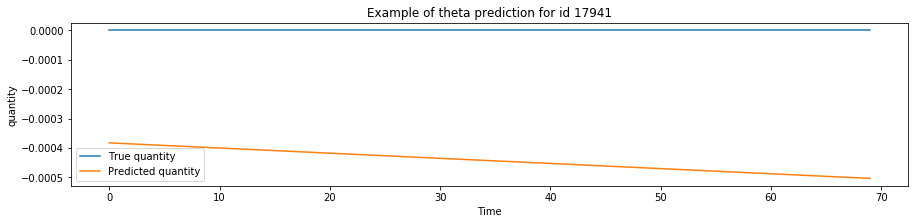

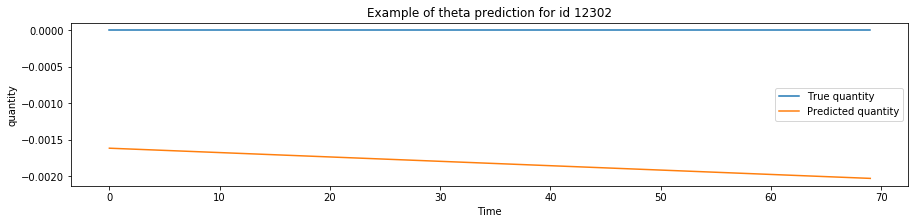

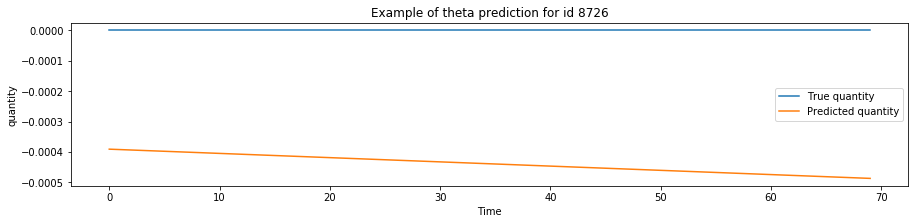

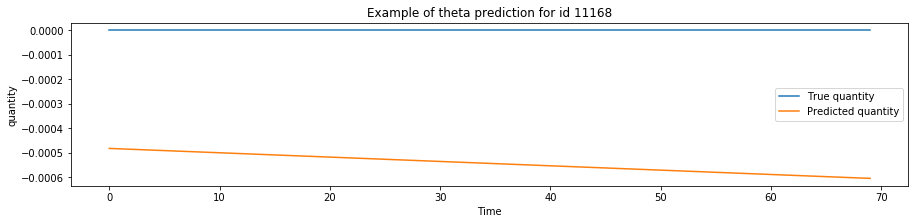

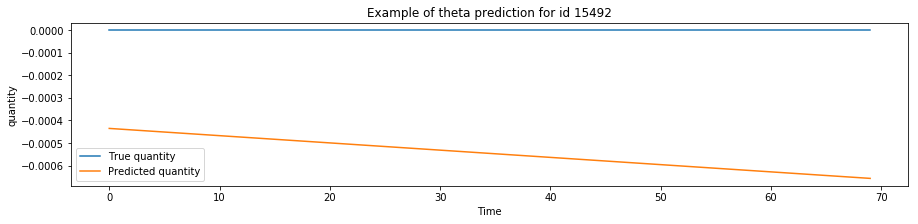

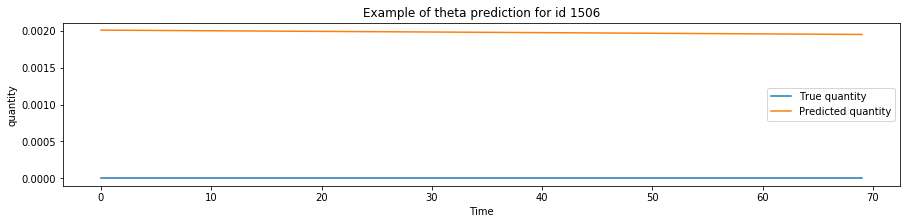

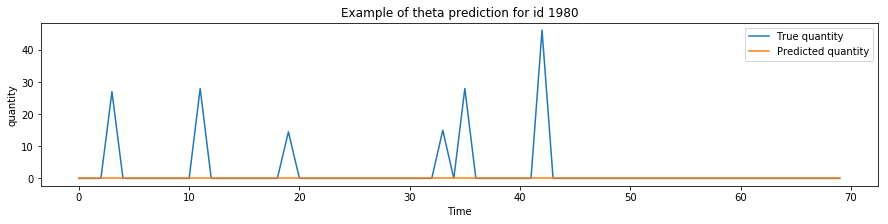

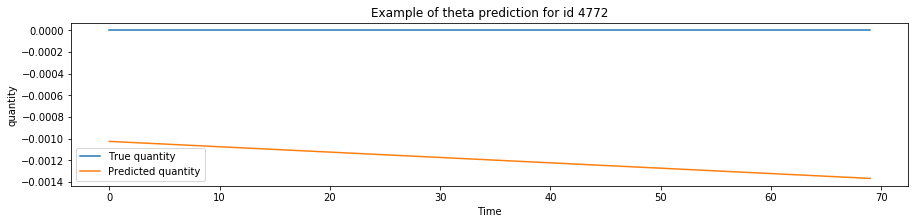

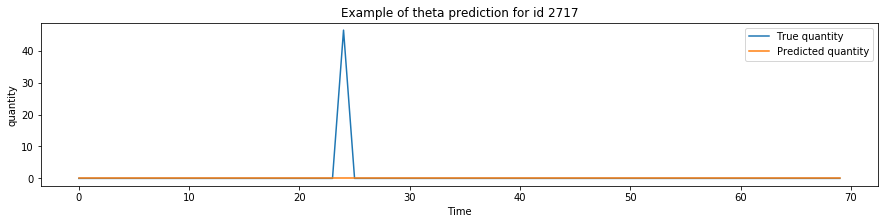

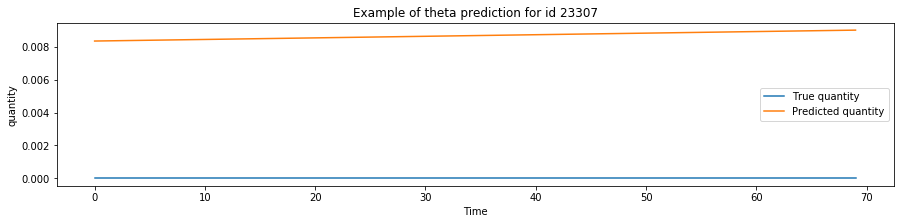

In [27]:
for x in range(10):
    rand = random.choice (test_targets.index)
    fig = plt.figure(figsize=(15,3))
    plt.plot(np.array(test_targets.loc[rand,:]).ravel(), label = 'True quantity')
    plt.plot(np.array(df_prediction.loc[rand,:]).ravel(), label = 'Predicted quantity')
    plt.xlabel('Time')
    plt.ylabel('quantity')
    plt.title('Example of theta prediction for id '+str(rand))
    plt.legend(); 